**Visualizing the outcome of Feature Learning**

Download the Dataset

In [1]:
!wget https://www.dropbox.com/s/5jh4hpuk2gcxaaq/all.zip
!unzip all.zip

--2024-08-12 05:26:53--  https://www.dropbox.com/s/5jh4hpuk2gcxaaq/all.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/g2lmp7n22c8q1v1zbv7jp/all.zip?rlkey=armbq1h6tuvxwnze5jxoaopmq [following]
--2024-08-12 05:26:54--  https://www.dropbox.com/scl/fi/g2lmp7n22c8q1v1zbv7jp/all.zip?rlkey=armbq1h6tuvxwnze5jxoaopmq
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc41af9c0470101b8e6203690170.dl.dropboxusercontent.com/cd/0/inline/CYc4wMNsRPeN1m2O0NEZu9oJ1okrRLibZYUIbBc1Fde04N3eNvfLziLeZ2MXBEz3BSYUaw3ghaR1yBF7avFRDvqRdET_ktHMwQxmsXaLvJZhq2hYyBKygb1l1oUZSP1yf_2_89NqGV-HgCOTLS55bz-5/file# [following]
--2024-08-12 05:26:55--  https://uc41af9c0470101b8e6203690170.dl.dropboxusercontent.com/cd/0/inline/CYc4wMNsRPeN1m2O

In [2]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, Dataset, DataLoader
from torch.optim import SGD, Adam
from torchvision import datasets
from torchsummary import summary
import numpy as np
import cv2
import matplotlib.pyplot as plt
from glob import glob
from imgaug import augmenters as iaa

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

Class that fetches data

In [4]:
tfm = iaa.Sequential(iaa.Resize(28))
class XO(Dataset):
  def __init__(self, folder):
    self.files = glob(folder)
  def __len__(self):
    return len(self.files)
  def __getitem__(self, ix):
    f = self.files[ix]
    im = tfm.augment_image(cv2.imread(f)[:, :, 0])
    im = im[None]
    cl = f.split('/')[-1].split('@')[0] == 'x'
    return torch.tensor(1 -im/255).to(device).float(), torch.tensor([cl]).float().to(device)

In [5]:
data = XO('/content/all/*')

Plot a sample of the images from the dataset

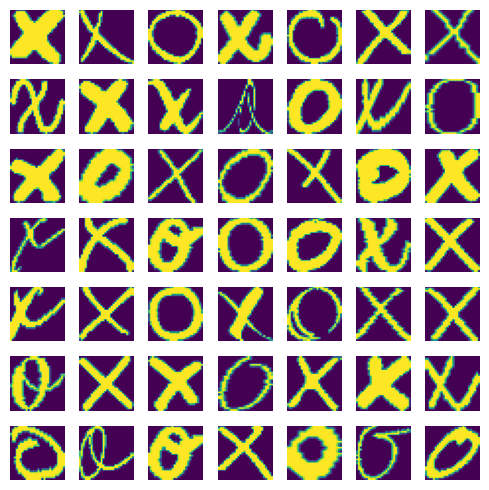

In [6]:
R, C = 7,7
fig, ax = plt.subplots(R, C, figsize=(5,5))
for label_class, plot_row in enumerate(ax):
    for plot_cell in plot_row:
        plot_cell.grid(False); plot_cell.axis('off')
        ix = np.random.choice(1000)
        im, label = data[ix]
        print()
        plot_cell.imshow(im[0].cpu())
plt.tight_layout()

**Model Architecture**

In [7]:
def get_model():
  model = nn.Sequential(
      nn.Conv2d(1, 64, kernel_size=3),
      nn.MaxPool2d(2),
      nn.ReLU(),
      nn.Conv2d(64, 128, kernel_size=3),
      nn.MaxPool2d(2),
      nn.ReLU(),
      nn.Flatten(),
      nn.Linear(3200, 256),
      nn.ReLU(),
      nn.Linear(256, 1),
      nn.Sigmoid()
  ).to(device)

  loss_fn = nn.BCELoss()
  optimizer = Adam(model.parameters(), lr=1e-3)
  return model, loss_fn, optimizer


In [8]:
def train_batch(x, y, model, opt, loss_fn):
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

def accuracy(x, y, model):
    with torch.no_grad():
        prediction = model(x)
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()

In [9]:
trn_dl = DataLoader(XO('/content/all/*'), batch_size=32, drop_last = True)

In [10]:
def val_loss(x, y, model):
  with torch.no_grad():
    prediction = model(x)
  val_loss = loss_fn(prediction, y)
  return val_loss.item()

In [11]:
model, loss_fn, optimizer = get_model()
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 26, 26]             640
         MaxPool2d-2           [-1, 64, 13, 13]               0
              ReLU-3           [-1, 64, 13, 13]               0
            Conv2d-4          [-1, 128, 11, 11]          73,856
         MaxPool2d-5            [-1, 128, 5, 5]               0
              ReLU-6            [-1, 128, 5, 5]               0
           Flatten-7                 [-1, 3200]               0
            Linear-8                  [-1, 256]         819,456
              ReLU-9                  [-1, 256]               0
           Linear-10                    [-1, 1]             257
          Sigmoid-11                    [-1, 1]               0
Total params: 894,209
Trainable params: 894,209
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

Train the model for 5 epochs

In [12]:
for epoch in range(5):
  epoch_loss = 0
  for ix, batch in enumerate(iter(trn_dl)):
    x, y = batch
    batch_loss = train_batch(x, y, model, optimizer, loss_fn)
    epoch_loss += batch_loss

  epoch_loss /= len(trn_dl)
  print(f'Epoch {epoch+1} Loss: {epoch_loss:.4f}')

Epoch 1 Loss: 0.1660
Epoch 2 Loss: 0.0575
Epoch 3 Loss: 0.0405
Epoch 4 Loss: 0.0237
Epoch 5 Loss: 0.0138


Fetch the image to check what the filters learn about the image

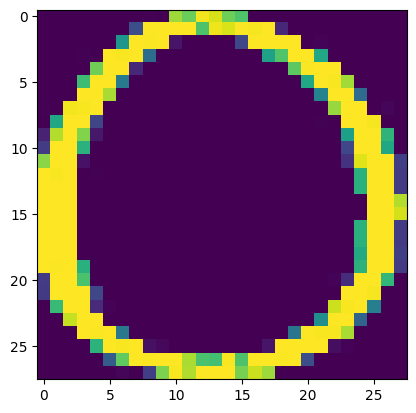

In [13]:
im, c = trn_dl.dataset[2]
plt.imshow(im[0].cpu())
plt.show()

Pass the image through the trained model and fetch the output of the first
layer.

In [14]:
first_layer = nn.Sequential(*list(model.children())[:1])
intermediate_output = first_layer(im[None])[0].detach()

Plot the output of the 64 filters

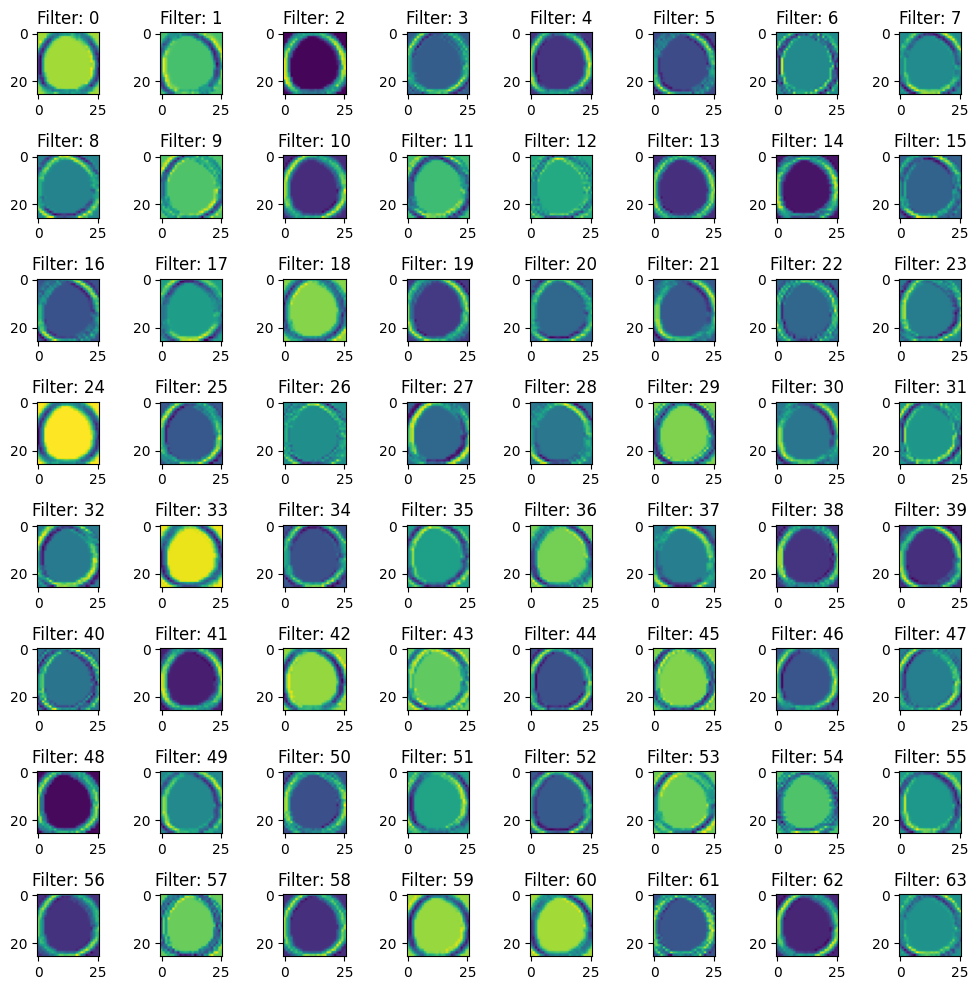

In [15]:
n = 8
fig, ax = plt.subplots(n, n, figsize=(10,10))
for ix, axis in enumerate(ax.flat):
    axis.set_title('Filter: '+str(ix))
    axis.imshow(intermediate_output[ix].cpu())
plt.tight_layout()
plt.show()

Pass multiple O images and inspect the output of the fourth filter across the
images

In [16]:
list(model.children())

[Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1)),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 ReLU(),
 Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1)),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 ReLU(),
 Flatten(start_dim=1, end_dim=-1),
 Linear(in_features=3200, out_features=256, bias=True),
 ReLU(),
 Linear(in_features=256, out_features=1, bias=True),
 Sigmoid()]

In [17]:
second_layer = nn.Sequential(*list(model.children()))[:4]
second_intermediate_output = second_layer(im[None])[0].detach()

In [18]:
second_intermediate_output.shape

torch.Size([128, 11, 11])

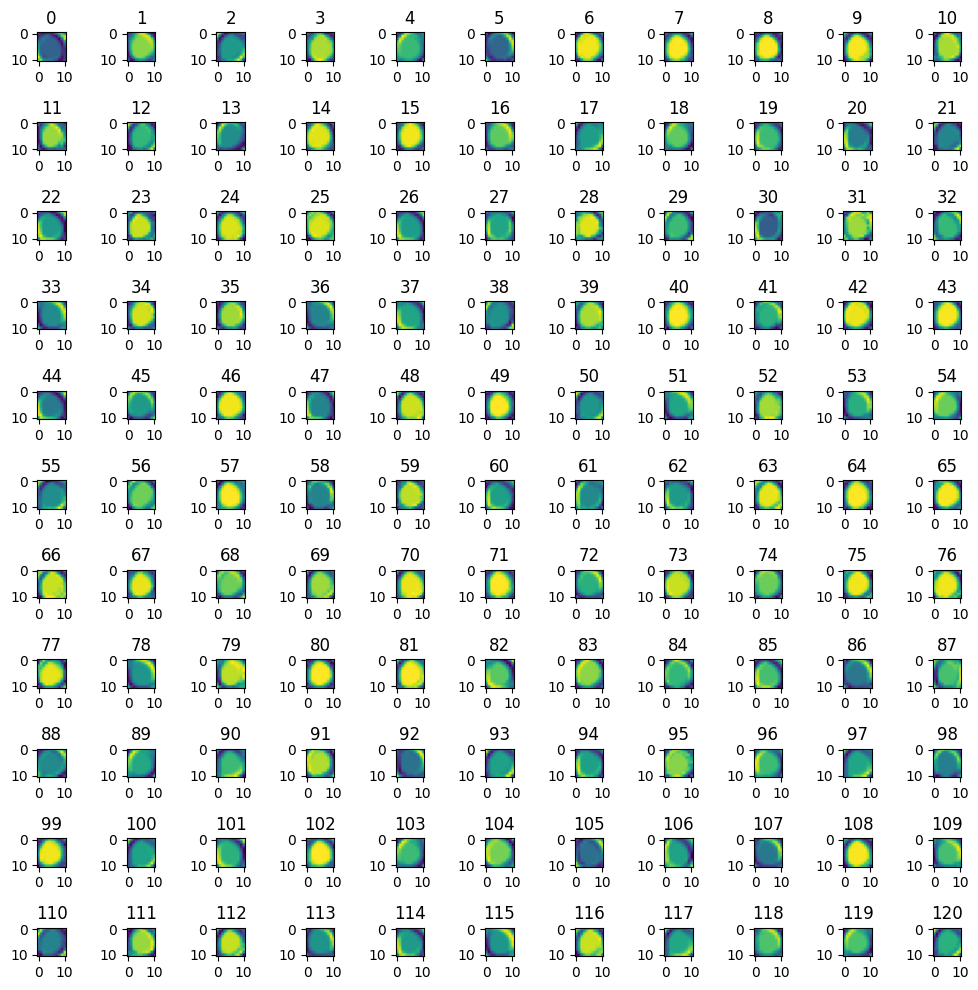

In [19]:
n = 11
fig, ax = plt.subplots(n, n, figsize=(10,10))
for ix, axis in enumerate(ax.flat):
    axis.imshow(second_intermediate_output[ix].cpu())
    axis.set_title(str(ix))
plt.tight_layout()
plt.show()

**Plot the activations of the fully connected layer**

In [20]:
# First fetch a larger sample of images
custom_dl = DataLoader(XO('/content/all/*'), batch_size=2498, drop_last=True)

In [21]:
x, y  = next(iter(custom_dl))
x2 = x[y==0]
x2 = x2.view(len(x2), 1, 28, 28)

In [22]:
# Fetch the flatten (fully connected) layer and pass thee preceding images through the model until they reach the flattened layer
flatten_layer = nn.Sequential(*list(model.children())[:7])
flatten_layer_output = flatten_layer(x2).detach()


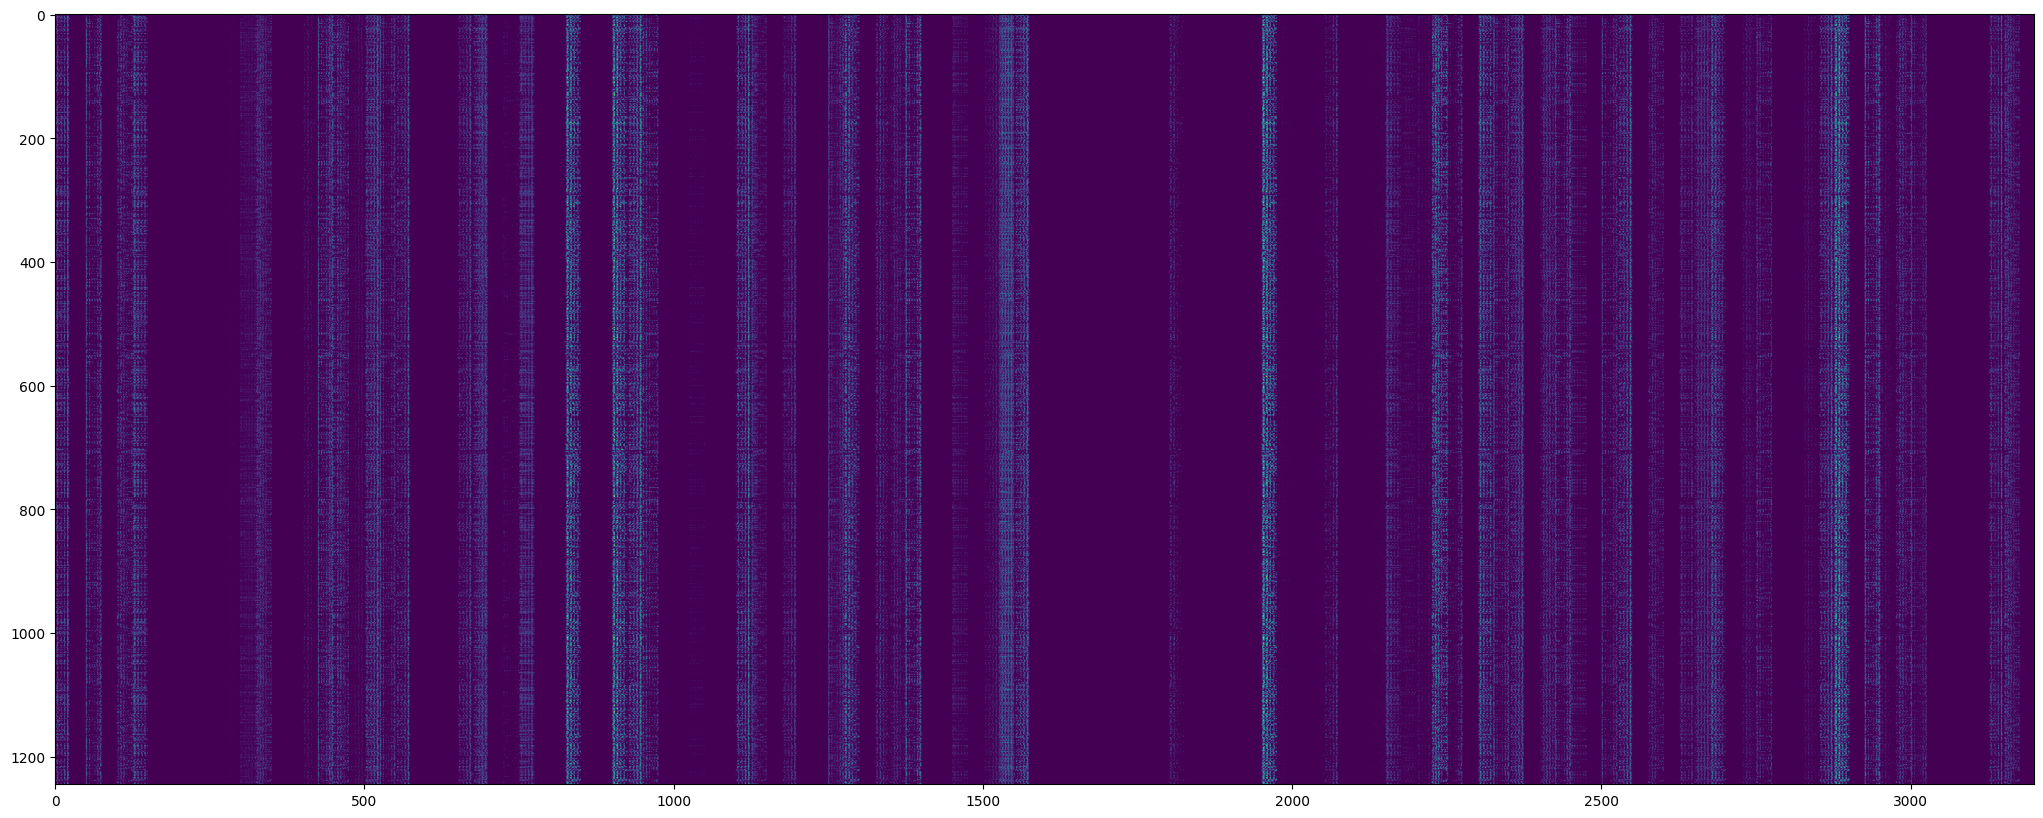

In [24]:
# Plot the flattened layer
plt.figure(figsize=(100, 10))
plt.imshow(flatten_layer_output.cpu())